# Customer Churn Prediction using Simple Artificial Neural Network

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Import data

In [2]:
# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Show first and last rows
print('first rows')
print(df.head())

print('last rows')
print(df.tail())

first rows
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

In [3]:
# Drop customerID
df = df.drop("customerID", axis=1)

# Data Exploration:

Understanding the dataset and key features.

In [4]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# Convert TotalCharges to numeric because the type for charges is object(string) now
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
# Fill the missing values with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
unique_values = {column: list(df[column].unique()) for column in df.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No phone service', 'No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
OnlineSecurity : ['No', 'Yes', 'No internet service']
OnlineBackup : ['Yes', 'No', 'No internet service']
DeviceProtection : ['No', 'Yes', 'No internet service']
TechSupport : ['No', 'Yes', 'No internet service']
StreamingTV : ['No', 'Yes', 'No internet service']
StreamingMovies : ['No', 'Yes', 'No internet service']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']


In [8]:
# converting "no phone service" and "no internet service" to "no"
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
      'StreamingTV', 'StreamingMovies']] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                                 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace('No internet service', 'No')

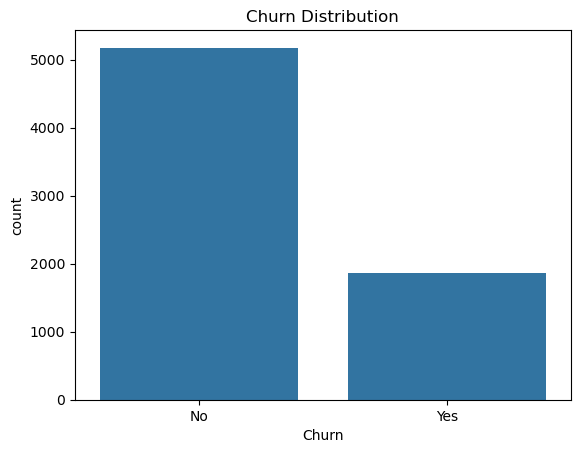

In [9]:
# Plot churn count
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

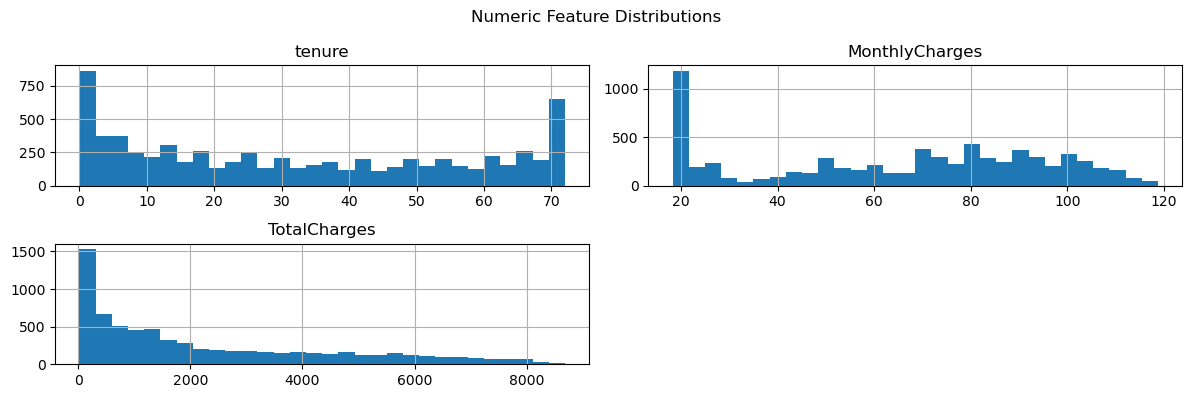

In [10]:
# Plot numeric histograms for main numeric features
df[["tenure", "MonthlyCharges", "TotalCharges"]].hist(bins=30, figsize=(12, 4))
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout(pad=1)
plt.show()

A lot of customers are new or paying very little.

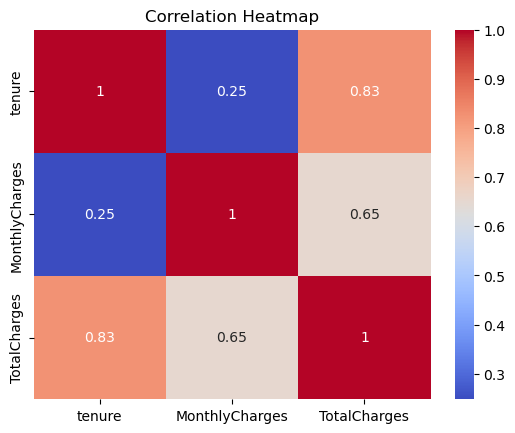

In [11]:
# Plot correlation heatmap
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Data Pre-processing

Cleaning the data, handling missing values, and normalizing features.

In [12]:
# Convert target column to binary
df["Churn"] = df["Churn"].str.strip().map({"No": 0, "Yes": 1})

# Encode all categorical columns (1 to yes, 0 to no)
for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [13]:
# Scale numeric features
scaler = StandardScaler()
df[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(df[["tenure", "MonthlyCharges", "TotalCharges"]])

In [14]:
df.tail()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,1,0,1,1,-0.340876,1,1,0,1,0,1,1,1,1,1,1,3,0.665992,-0.128655,0
7039,0,0,1,1,1.613701,1,1,1,0,1,1,0,1,1,1,1,1,1.277533,2.243151,0
7040,0,0,1,1,-0.870241,0,0,0,1,0,0,0,0,0,0,1,2,-1.168632,-0.854469,0
7041,1,1,1,0,-1.155283,1,1,1,0,0,0,0,0,0,0,1,3,0.320338,-0.872062,1
7042,1,0,0,0,1.369379,1,0,1,1,0,1,1,1,1,2,1,0,1.358961,2.014288,0


In [15]:
# Split dataset to features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

Implementing and evaluating machine learning model - Simple ANN

In [16]:
# Build model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

C:\Users\anast\anaconda\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=35, validation_split=0.2)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6351 - loss: 0.6363 - val_accuracy: 0.7764 - val_loss: 0.4660
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7527 - loss: 0.4909 - val_accuracy: 0.8057 - val_loss: 0.4190
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7778 - loss: 0.4638 - val_accuracy: 0.7995 - val_loss: 0.4151
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.4587 - val_accuracy: 0.8110 - val_loss: 0.4112
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.4513 - val_accuracy: 0.8110 - val_loss: 0.4109
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7862 - loss: 0.4358 - val_accuracy: 0.8057 - val_loss: 0.4101
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7714 - loss: 0.4620 - val_accuracy: 0.8066 - val_loss: 0.4094
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7802 - loss: 0.4499 - val_accu

In [33]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Evaluation

Evaluate the performance of the model.

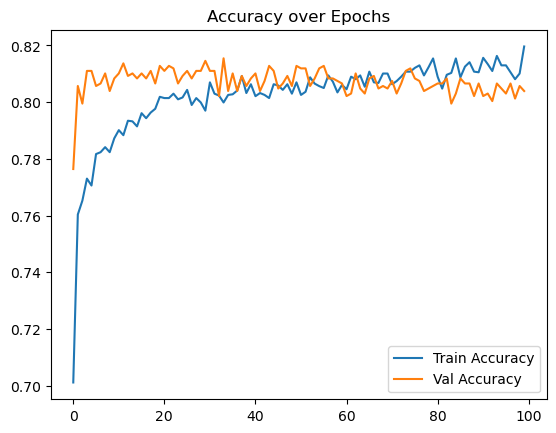

In [20]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

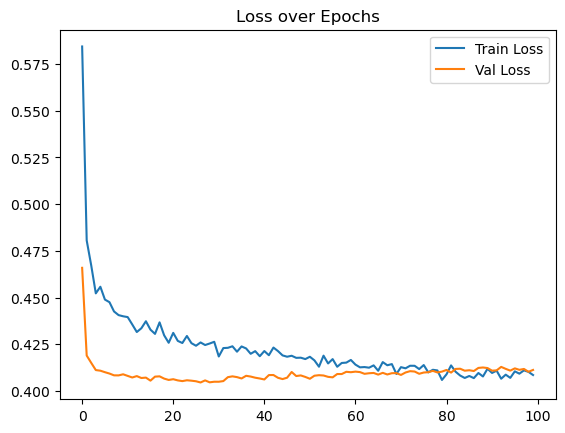

In [21]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

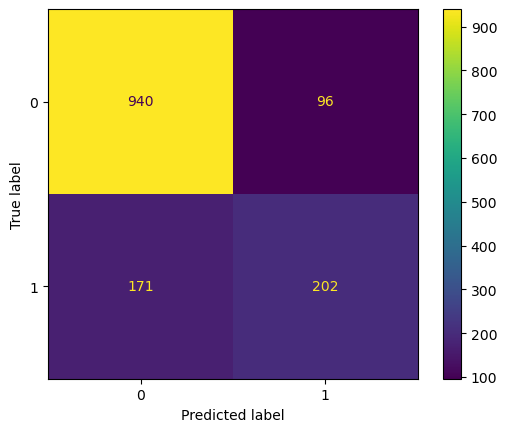

Accuracy: 0.81
              precision    recall  f1-score   support

          no       0.85      0.91      0.88      1036
         yes       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [26]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

target_names = ['no', 'yes']
print(classification_report(y_test, y_pred, target_names=target_names))